In [1]:
import matplotlib as mpl

font = {'family' : 'serif',
        'size'   : 12}

mpl.rc('font', **font)
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import matplotlib.ticker as ticker


import numpy as np
import glob
from tqdm import tqdm


In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [3]:
case_dir = "data/article_data/jgr_5/case_00714/"

In [4]:
nc_files = glob.glob(case_dir+"data/*_atm.nc")
times = [int(f.split("/")[-1].split("_")[0]) for f in nc_files]
mask = np.argsort(times)

sorted_t, sorted_f = [],[]
for i in mask:
    sorted_t.append(times[i])
    sorted_f.append(nc_files[i])
nfiles = len(sorted_t)
print(nfiles)

242


In [5]:
sorted_nc = []
pbar = tqdm(desc="NetCDFS", total=nfiles)
for i in range(nfiles):
    sorted_nc.append(lg.read_nc(sorted_f[i]))
    pbar.update(1)
print(" ")

NetCDFS:   0%|          | 0/242 [00:00<?, ?it/s]

NetCDFS:  99%|█████████▉| 240/242 [00:04<00:00, 54.12it/s]

In [6]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

xs = []  # times
ys = []  # pressures
zs = []  # values
rs = []  # radiating levels (pressure)

stride = 1

ybot, ytop = 1.0, 0.1
for i in range(2,nfiles,stride):
    nc = sorted_nc[i]
    xs.append(np.ones(np.shape(nc["p"]))*sorted_t[i])
    y = nc["p"] * 1.0e-5
    ys.append(y)

    dF = nc["fl_N"][1:]- nc["fl_N"][:-1]
    dP = nc["pl"][1:]  - nc["pl"][:-1]
    hr = (nc["gravity"][:] / nc["cp"] ) * (dF/dP) * 86400.0 

    hr_s = []
    for j in range(len(hr)):
        h = abs(hr[j])
        if h < 1.0:
            h = 0.0
        else:
            h = np.log10(h) * np.sign(hr[j])
        hr_s.append(h)

    # hr_s = np.log10(np.abs(hr)) * np.sign(hr)

    zs.append(hr_s)
    
    ybot = max(ybot, np.amax(y))
    ytop = min(ytop, np.amin(y))

    t_top = nc["tmp"][0]
    for j,tmp in enumerate(nc["tmp"]):
        if tmp > t_top + 0.001:
            if j > 1:
                rs.append(y[j])
            else:
                rs.append(np.nan)
            break 

minz, maxz = np.amin(zs), np.amax(zs)
absz = max(maxz, abs(minz))
print(absz)

x_plt, y_plt, z_plt = [],[],[]
for i in range(len(ys)):
    for j in range(len(ys[0])):
        x_plt.append(xs[i][j])
        y_plt.append(ys[i][j])
        z_plt.append(zs[i][j])
xi = np.linspace(np.amin(x_plt), np.amax(x_plt), 400)
yi = np.logspace(np.log10(np.amin(y_plt)), np.log10(np.amax(y_plt)), 150)
xi,yi = np.meshgrid(xi,yi)
zi = griddata((x_plt,y_plt),z_plt,(xi,yi),method='linear', rescale=True, fill_value=np.nan)

4.769382885730839


4.769382885730839


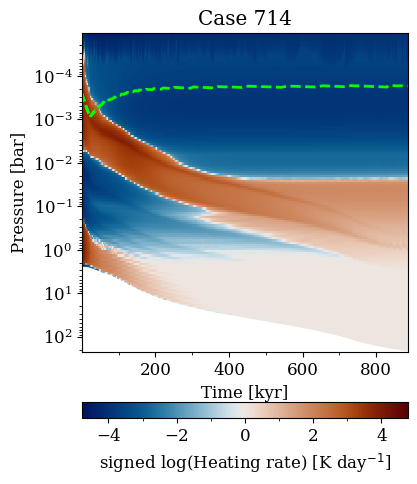

In [7]:
# fig
plt.close("all")
fig,ax = plt.subplots(1,1, figsize=(4.2,5))

pct_max = 100

if pct_max < 99.99:
    extend="both"
    absz = np.percentile(np.abs(zs), pct_max)
else:
    extend="neither"
print(absz)

# cmap
norm = "linear"
cmap = sci_colormaps["vik"]

xscale = 1.0e-3

# plot data
cf = ax.pcolormesh(xi*xscale,yi,zi, norm=norm, cmap=cmap, rasterized=True, vmin=-absz, vmax=absz)

# plot decorations
x_1d = np.array(xs).T[0]*xscale
ax.plot(x_1d, rs, lw=2, color='lime', linestyle='dashed')  # stratosphere level
ax.fill_between(x_1d, np.ones(np.shape(x_1d))*1e99, np.array(ys).T[-1], color='white') # surface pressure

# colorbar
# cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cax = make_axes_locatable(ax).append_axes('bottom', size='5%', pad=0.5)
cbar = fig.colorbar(cf, cax=cax, orientation='horizontal', extend=extend) 
cbar.set_label(r"signed log(Heating rate) [K day$^{-1}$]")
cbar.ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# configure
case_num = int(case_dir.split("case_")[-1][:-1])
ax.set_yscale("log")
ax.set_xlabel("Time [kyr]")
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))

title = "Case %d"%case_num
ax.set_title(title)

ax.set_xlim(1e3*xscale, sorted_t[-1]*xscale)
ax.set_ylim(ybot, ytop)
ax.set_ylabel("Pressure [bar]")
# ax.set_yticklabels([])

# save
fig.savefig("output/recent_heat2d_%05d.pdf"%case_num, bbox_inches='tight', dpi=200)

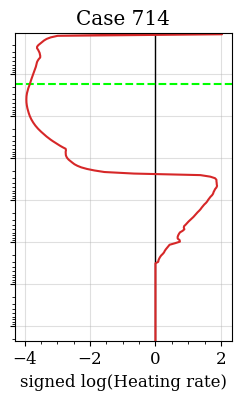

NetCDFS: 100%|██████████| 242/242 [00:19<00:00, 54.12it/s]

In [8]:
plt.close("all")

final = sorted_nc[-1]
fin_pr = np.array(final["p"][:]) * 1.0e-5
fin_hr = np.array(zs[-1])

fig,ax = plt.subplots(1,1, figsize=(2.8,4))

ax.axvline(0, color='k', lw=1)
ax.axhline(rs[-1], color='lime', ls='dashed')
ax.plot(fin_hr, fin_pr, lw=1.5, color='tab:red')

ax.grid(alpha=0.4)

ax.set_xlabel("signed log(Heating rate)")
# ax.set_xscale("symlog")

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.set_ylim(top=np.amin(fin_pr), bottom=np.amax(fin_pr))
# ax.set_ylabel("Pressure [bar]")
ax.set_yscale("log")
ax.set_yticklabels([])

ax.set_title(title)


plt.show()
fig.savefig("output/recent_heat1d_%05d.pdf"%case_num, bbox_inches='tight', dpi=200)